In [13]:
# Core libraries
import numpy as np
import os
from pathlib import Path
import pickle
from tqdm import tqdm

# Image processing and landmark detection
import cv2
import mediapipe as mp

# Scikit-learn for the k-NN model and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully.")

Libraries imported successfully.


In [21]:
def extract_landmarks(image):
    """Reads a single BGR image and returns a normalized 63-point MediaPipe hand landmark vector."""
    # Using 'with' for automatic resource management
    with mp.solutions.hands.Hands(
        static_image_mode=True, 
        max_num_hands=1, 
        min_detection_confidence=0.5
    ) as hands:
        
        # MediaPipe expects RGB images, but OpenCV loads as BGR
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = hands.process(image_rgb)
        
        if not results.multi_hand_landmarks:
            return None # Return None if no hand is detected
        
        # Extract and normalize landmarks
        hand_landmarks = results.multi_hand_landmarks[0]
        landmarks = []
        wrist_coords = hand_landmarks.landmark[0]
        for lm in hand_landmarks.landmark:
            landmarks.extend([lm.x - wrist_coords.x, lm.y - wrist_coords.y, lm.z - wrist_coords.z])
        return np.array(landmarks)

# --- Load data and extract features ---
DATA_DIR = Path('processed_for_knn') # IMPORTANT: Make sure this is your data folder
features = []
labels = []

# Loop through the folders and images to extract features
label_folders = [d for d in DATA_DIR.iterdir() if d.is_dir()]
for label_folder in tqdm(sorted(label_folders), desc="Extracting Features"):
    for img_path in label_folder.glob('*.jpg'):
        image = cv2.imread(str(img_path))
        if image is not None:
            landmarks = extract_landmarks(image)
            if landmarks is not None:
                features.append(landmarks)
                labels.append(label_folder.name)

X = np.array(features)
y = np.array(labels)

print(f"\nFeature extraction complete. Found {len(X)} usable samples.")
print(f"Feature shape: {X.shape}, Labels shape: {y.shape}")
print(y[:10])  # Display first 10 labels for verification
print(X[:10])  # Display first 10 feature vectors for verification

Extracting Features:   0%|          | 0/18 [00:00<?, ?it/s]I0000 00:00:1751904640.124597   40647 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1751904640.131088   97362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751904640.136149   97362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1751904640.166175   40647 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M3
W0000 00:00:1751904640.170549   97373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751904640.174587   97377 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedbac


Feature extraction complete. Found 89 usable samples.
Feature shape: (89, 63), Labels shape: (89,)
['a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'be']
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.74655628e-03
  -3.85431647e-02 -1.65360145e-02 -3.10970545e-02 -7.36148357e-02
  -2.22959504e-02 -5.29248714e-02 -1.03778392e-01 -2.77213663e-02
  -5.90856671e-02 -1.32315934e-01 -3.22310798e-02 -9.67516601e-02
  -5.99221289e-02  4.48818839e-03 -1.30368084e-01 -7.26449490e-02
  -2.60576691e-03 -1.36808991e-01 -8.27354789e-02 -1.22568946e-02
  -1.33430719e-01 -9.05148089e-02 -1.82417020e-02 -1.05594397e-01
  -3.57826352e-02  7.26238972e-03 -1.37519896e-01 -4.38197851e-02
   4.72773806e-03 -1.45135313e-01 -5.02564311e-02 -2.75161249e-03
  -1.45969003e-01 -5.68146408e-02 -7.93280025e-03 -1.08775973e-01
  -1.09558702e-02  6.50147077e-03 -1.38918281e-01 -1.81831717e-02
   3.86122832e-03 -1.49549335e-01 -2.35670805e-02  6.27512950e-04
  -1.53891742e-01 -2.97889709e-02 -1.53786390e-03 -1.06232256e-01

In [22]:
# Encode string labels to numbers (e.g., 'A' -> 0, 'B' -> 1)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded # Ensures train/test sets have proportional class representation
)

print(f"Data split into {len(X_train)} training samples and {len(X_test)} test samples.")

Data split into 71 training samples and 18 test samples.


In [24]:
# Initialize and train the k-NN model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='cosine')
knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# --- Evaluation ---
print("\n--- k-NN Model Evaluation ---")
accuracy = np.mean(y_pred == y_test)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%\n")

# Print a detailed report showing precision, recall, and f1-score for each letter
print("Classification Report:")
print(classification_report(y_test, y_pred, labels = np.unique(y_encoded), target_names=label_encoder.classes_))


--- k-NN Model Evaluation ---
Test Set Accuracy: 88.89%

Classification Report:
              precision    recall  f1-score   support

           a       1.00      1.00      1.00         2
          be       0.00      0.00      0.00         2
         che       1.00      1.00      1.00         5
          ke       1.00      1.00      1.00         1
         kgn       1.00      1.00      1.00         2
          qe       1.00      1.00      1.00         3
          te       0.60      1.00      0.75         3
          ye       0.00      0.00      0.00         0

    accuracy                           0.89        18
   macro avg       0.70      0.75      0.72        18
weighted avg       0.82      0.89      0.85        18



/Users/eyoas.zewd/Documents/amharic/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/eyoas.zewd/Documents/amharic/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/eyoas.zewd/Documents/amharic/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

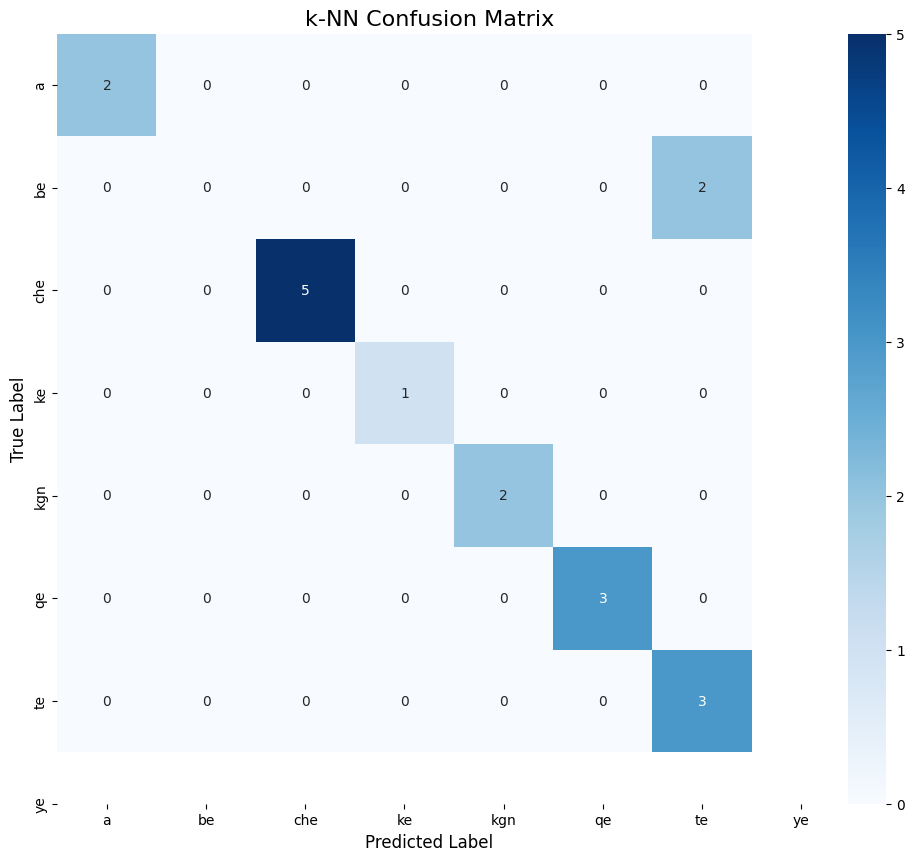

In [25]:
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('k-NN Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

In [26]:
# Save the trained model and the encoder for later use
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)
with open('label_encoder_knn.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

print("✅ k-NN model saved as 'knn_model.pkl'")
print("✅ k-NN label encoder saved as 'label_encoder_knn.pkl'")

✅ k-NN model saved as 'knn_model.pkl'
✅ k-NN label encoder saved as 'label_encoder_knn.pkl'
